In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.express as px


In [0]:
train= pd.read_csv('/content/drive/My Drive/Untitled Folder/train.csv')

test= pd.read_csv('/content/drive/My Drive/Untitled Folder/test.csv')

In [0]:
# create features
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

train['EntryHeading'] = train['EntryHeading'].map(directions)
train['ExitHeading'] = train['ExitHeading'].map(directions)

test['EntryHeading'] = test['EntryHeading'].map(directions)
test['ExitHeading'] = test['ExitHeading'].map(directions)


city_dum =pd.get_dummies(train['City'], prefix= None)
train = pd.concat([train, city_dum], axis=1)
train = train.drop('City', axis=1)

city_dum2 =pd.get_dummies(test['City'], prefix=None)
test = pd.concat([test, city_dum2], axis=1)
test = test.drop('City', axis=1)

train['Weekend'] = np.where(train['Weekend']==True, 1, 0)

test['Weekend'] = np.where(test['Weekend']==True, 1, 0)

train['same_street'] = np.where(train['EntryStreetName']==train['ExitStreetName'], 1 , 0)

test['same_street'] = np.where(test['EntryStreetName']==test['ExitStreetName'], 1 , 0)

train['diff_direction'] = train['EntryHeading'] - train['ExitHeading']

test['diff_direction'] = test['EntryHeading'] - test['ExitHeading']



In [0]:
# 위도, 경도 합
train['loca_sum'] = train['Latitude'] + train['Longitude']

test['loca_sum'] = test['Latitude'] + test['Longitude']
    
# 랭킹 매김 
rankk = train['loca_sum'].drop_duplicates().reset_index().reset_index().drop('index', axis=1)

rankk_test = test['loca_sum'].drop_duplicates().reset_index().reset_index().drop('index', axis=1)

dict  = {}
for i in range(len(rankk)):
  dict[rankk['loca_sum'][i]] = i
  
train['loca_rank'] = train['loca_sum'].map(dict)

dict_test  = {}
for i in range(len(rankk_test)):
  dict_test[rankk_test['loca_sum'][i]] = i
  
test['loca_rank'] = test['loca_sum'].map(dict_test)


# 현재 로우 랭킹 -1 , +1의 위도경도 합을 구하는 컬럼 추가
# 그 컬럼값과 현재 로우의 위도경도 합의 차이를 구함
dict2 = {}
values = list(dict.keys())
for i in range(len(dict)):
  if i == 0:
    dict2[i] = np.abs(values[i] - values[i+1])
  elif i<4731:
    if np.abs(values[i] - values[i+1]) >= np.abs(values[i] - values[i-1]):
      dict2[i] = np.abs(values[i] - values[i-1])
    else:
      dict2[i] = np.abs(values[i] - values[i+1])
  else:    
    dict2[i] = np.abs(values[i] - values[i-1])
    
train['nearest'] = train['loca_rank'].map(dict2)

dict2_test = {}
values_test = list(dict_test.keys())
for i in range(len(dict_test)):
  if i == 0:
    dict2_test[i] = np.abs(values_test[i] - values_test[i+1])
  elif i<4731:
    if np.abs(values_test[i] - values_test[i+1]) >= np.abs(values_test[i] - values_test[i-1]):
      dict2_test[i] = np.abs(values_test[i] - values_test[i-1])
    else:
      dict2_test[i] = np.abs(values_test[i] - values_test[i+1])
  else:    
    dict2_test[i] = np.abs(values_test[i] - values_test[i-1])
test['nearest'] = test['loca_rank'].map(dict2_test)

In [6]:
fig = px.scatter_mapbox(train[train.Atlanta==1], lat="Latitude", lon="Longitude",size="TotalTimeStopped_p20",color="TotalTimeStopped_p20",  
                        color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
fig = px.scatter_mapbox(train[train.Boston==1], lat="Latitude", lon="Longitude",size="TotalTimeStopped_p20",color="TotalTimeStopped_p20",  
                        color_continuous_scale=px.colors.sequential.Viridis, size_max=15, zoom=10)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

- 길이가 긴 길은 큰 길일 확률이 높다
  - 같은 EntryStreetName 사이에 가장 위도 경도 차이가 큰 값을 찾는다


In [0]:
# (train) make the length of entry street and exit street 
entry_max=train[['EntryStreetName','Latitude','Longitude']].groupby('EntryStreetName').max().reset_index()
entry_min=train[['EntryStreetName','Latitude','Longitude']].groupby('EntryStreetName').min().reset_index()

entry_dist = pd.merge(entry_max, entry_min, on = 'EntryStreetName')

exit_max=train[['ExitStreetName','Latitude','Longitude']].groupby('ExitStreetName').max().reset_index()
exit_min=train[['ExitStreetName','Latitude','Longitude']].groupby('ExitStreetName').min().reset_index()

exit_dist = pd.merge(exit_max, exit_min, on = 'ExitStreetName')

entry_dist['Entry_length'] = np.sqrt((np.power((entry_dist['Latitude_x']-entry_dist['Latitude_y']),2) + np.power((entry_dist['Longitude_x']-entry_dist['Longitude_y']),2)))
exit_dist['Exit_length'] = np.sqrt((np.power((exit_dist['Latitude_x']-exit_dist['Latitude_y']),2) + np.power((exit_dist['Longitude_x']-exit_dist['Longitude_y']),2)))



# 완전한 street 길이
exit_dist = exit_dist.rename(columns={'ExitStreetName':'EntryStreetName'})
street_length = pd.merge(entry_dist, exit_dist, on = 'EntryStreetName', how='outer')

street_length['Latitude_max'] = np.where(street_length['Latitude_x_x']>=street_length['Latitude_x_y'],street_length['Latitude_x_x'], street_length['Latitude_x_y'])
street_length['Latitude_min'] = np.where(street_length['Latitude_y_x']<=street_length['Latitude_y_y'],street_length['Latitude_y_x'], street_length['Latitude_y_y'])

street_length['Longitude_max'] = np.where(street_length['Longitude_x_x']>=street_length['Longitude_x_y'],street_length['Longitude_x_x'], street_length['Longitude_x_y'])
street_length['Longitude_min'] = np.where(street_length['Longitude_y_x']<=street_length['Longitude_y_y'],street_length['Longitude_y_x'], street_length['Longitude_y_y'])

street_length['street_length'] = np.sqrt((np.power((street_length['Latitude_max']-street_length['Latitude_min']),2) + np.power((street_length['Longitude_max']-street_length['Longitude_min']),2)))

dict_entry  = {}
for i in range(len(street_length)):
  dict_entry[street_length['EntryStreetName'][i]] = street_length['street_length'][i]
  
train['Entry_length'] = train['EntryStreetName'].map(dict_entry)
train['Exit_length'] = train['ExitStreetName'].map(dict_entry)

In [0]:
# (test) make the length of entry street and exit street 
entry_max=test[['EntryStreetName','Latitude','Longitude']].groupby('EntryStreetName').max().reset_index()
entry_min=test[['EntryStreetName','Latitude','Longitude']].groupby('EntryStreetName').min().reset_index()

entry_dist = pd.merge(entry_max, entry_min, on = 'EntryStreetName')

exit_max=test[['ExitStreetName','Latitude','Longitude']].groupby('ExitStreetName').max().reset_index()
exit_min=test[['ExitStreetName','Latitude','Longitude']].groupby('ExitStreetName').min().reset_index()

exit_dist = pd.merge(exit_max, exit_min, on = 'ExitStreetName')

entry_dist['Entry_length'] = np.sqrt((np.power((entry_dist['Latitude_x']-entry_dist['Latitude_y']),2) + np.power((entry_dist['Longitude_x']-entry_dist['Longitude_y']),2)))
exit_dist['Exit_length'] = np.sqrt((np.power((exit_dist['Latitude_x']-exit_dist['Latitude_y']),2) + np.power((exit_dist['Latitude_y']-exit_dist['Longitude_y']),2)))



# 완전한 street 길이
exit_dist = exit_dist.rename(columns={'ExitStreetName':'EntryStreetName'})
street_length = pd.merge(entry_dist, exit_dist, on = 'EntryStreetName', how='outer')

street_length['Latitude_max'] = np.where(street_length['Latitude_x_x']>=street_length['Latitude_x_y'],street_length['Latitude_x_x'], street_length['Latitude_x_y'])
street_length['Latitude_min'] = np.where(street_length['Latitude_y_x']<=street_length['Latitude_y_y'],street_length['Latitude_y_x'], street_length['Latitude_y_y'])

street_length['Longitude_max'] = np.where(street_length['Longitude_x_x']>=street_length['Longitude_x_y'],street_length['Longitude_x_x'], street_length['Longitude_x_y'])
street_length['Longitude_min'] = np.where(street_length['Longitude_y_x']<=street_length['Longitude_y_y'],street_length['Longitude_y_x'], street_length['Longitude_y_y'])

street_length['street_length'] = np.sqrt((np.power((street_length['Latitude_max']-street_length['Latitude_min']),2) + np.power((street_length['Longitude_max']-street_length['Longitude_min']),2)))

dict_entry  = {}
for i in range(len(street_length)):
  dict_entry[street_length['EntryStreetName'][i]] = street_length['street_length'][i]
  
test['Entry_length'] = test['EntryStreetName'].map(dict_entry)
test['Exit_length'] = test['ExitStreetName'].map(dict_entry)

- 길의 길이가 길수록 큰 길이라고 정의했다. 그래프를 보면 큰 길에서 정지시간이 길어진다

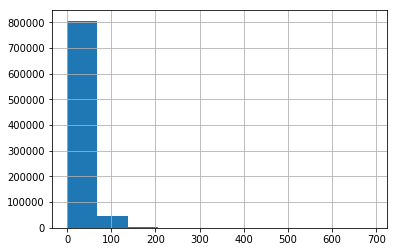

In [114]:
train['TotalTimeStopped_p80'].hist()

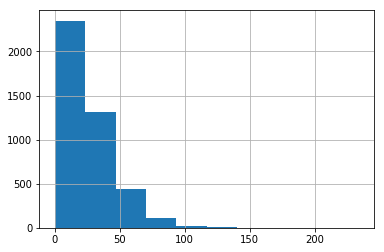

In [115]:
train[train['street_length_ex']>10]['TotalTimeStopped_p80'].hist()

- 큰 길은 여러 개의 교차로가 있을 것이다

In [143]:
train.columns

Index(['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'EntryStreetName',
       'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Hour', 'Weekend',
       'Month', 'Path', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40',
       'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80',
       'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40',
       'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60',
       'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20',
       'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50',
       'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'Entry_length',
       'Exit_length', 'street_length', 'street_length_ex', 'Atlanta', 'Boston',
       'Chicago', 'Philadelphia', 'same_street', 'diff_direction', 'loca_sum',
       'loca_rank', 'nearest', 'Entry_count', 'Exit_count'],
      dtype='object')

In [0]:
entry_count=train[['IntersectionId','EntryStreetName','Latitude','Longitude']].groupby(['EntryStreetName', 'IntersectionId']).count().reset_index()
entry_count2 = entry_count[['IntersectionId','EntryStreetName']].groupby('EntryStreetName').count().reset_index()

dict_count  = {}
for i in range(len(entry_count2)):
  dict_count[entry_count2['EntryStreetName'][i]] = entry_count2['IntersectionId'][i]
  
train['Entry_count'] = train['EntryStreetName'].map(dict_count)

# exit train
exit_count=train[['IntersectionId','ExitStreetName','Latitude','Longitude']].groupby(['ExitStreetName', 'IntersectionId']).count().reset_index()
exit_count2 = exit_count[['IntersectionId','ExitStreetName']].groupby('ExitStreetName').count().reset_index()

dict_count  = {}
for i in range(len(exit_count2)):
  dict_count[exit_count2['ExitStreetName'][i]] = exit_count2['IntersectionId'][i]
  
train['Exit_count'] = train['ExitStreetName'].map(dict_count)

In [0]:
entry_count=test[['IntersectionId','EntryStreetName','Latitude','Longitude']].groupby(['EntryStreetName', 'IntersectionId']).count().reset_index()
entry_count2 = entry_count[['IntersectionId','EntryStreetName']].groupby('EntryStreetName').count().reset_index()

dict_count  = {}
for i in range(len(entry_count2)):
  dict_count[entry_count2['EntryStreetName'][i]] = entry_count2['IntersectionId'][i]
  
test['Entry_count'] = test['EntryStreetName'].map(dict_count)

# exit test
exit_count=test[['IntersectionId','ExitStreetName','Latitude','Longitude']].groupby(['ExitStreetName', 'IntersectionId']).count().reset_index()
exit_count2 = exit_count[['IntersectionId','ExitStreetName']].groupby('ExitStreetName').count().reset_index()

dict_count  = {}
for i in range(len(exit_count2)):
  dict_count[exit_count2['ExitStreetName'][i]] = exit_count2['IntersectionId'][i]
  
test['Exit_count'] = test['ExitStreetName'].map(dict_count)

In [146]:
train_c = train.corr()
train_c['TotalTimeStopped_p80'].sort_values(ascending=False)

TotalTimeStopped_p80       1.000000
TimeFromFirstStop_p80      0.913528
TotalTimeStopped_p60       0.871995
TimeFromFirstStop_p60      0.837086
TotalTimeStopped_p50       0.795859
TimeFromFirstStop_p50      0.777466
TotalTimeStopped_p40       0.733401
TimeFromFirstStop_p40      0.724047
TimeFromFirstStop_p20      0.543688
TotalTimeStopped_p20       0.536729
DistanceToFirstStop_p50    0.477236
DistanceToFirstStop_p40    0.471547
DistanceToFirstStop_p60    0.470733
DistanceToFirstStop_p80    0.439235
DistanceToFirstStop_p20    0.405978
Atlanta                    0.082163
Boston                     0.060499
Hour                       0.059766
nearest                    0.008529
diff_direction             0.004880
EntryHeading               0.002780
ExitHeading               -0.000925
Month                     -0.004858
Longitude                 -0.017663
Chicago                   -0.018761
street_length_ex          -0.024979
Exit_length               -0.029212
loca_sum                  -0

In [153]:

# 0920 변수 추가
np.random.seed(42)

# final selected columns
train_final = train[['RowId','IntersectionId','Latitude','Longitude', 'EntryHeading','ExitHeading',
                   'Hour','Weekend','Month','Atlanta','Boston','Chicago','Philadelphia', 'same_street','nearest', 'diff_direction', 'Entry_length', 'Exit_length','Entry_count','Exit_count']]

test_final = test[['RowId','IntersectionId','Latitude','Longitude', 'EntryHeading','ExitHeading',
                   'Hour','Weekend','Month','Atlanta','Boston','Chicago','Philadelphia', 'same_street','nearest','diff_direction', 'Entry_length', 'Exit_length','Entry_count','Exit_count']]

dtest = xgb.DMatrix(test_final[test_final.columns[1:]]) # transform the test_final for DMatrix model
results = [] # save the six predictions

# Run Xgbregressor 6 times as the request of the coompetition.
for target in ['TotalTimeStopped','DistanceToFirstStop']:
    for percent in ['_p20', '_p50', '_p80']:
        sub_target = train[target + percent]
        

        # split the train set as train and valid. I will use the given test data for the test of my model.
        X_train, X_valid, y_train, y_valid = train_test_split(train_final[train_final.columns[1:]], 
                                                            sub_target, test_size=0.2, random_state=42)

        # parameters
        xgb_pars = {'learning_rate': 0.02, 
          'gamma' : 0.1, 
          'min_child_weight' : 1,
          'nthread' : 15,
          'max_depth' : 15,
          'subsample' : 0.5,
          'eval_metric' : 'rmse',
          'colsample_bytree' : 0.8, 
          'num_boost_round' : 500,
          'n_estimators': 500,
          'max_leaves': 10,
          'objective': 'reg:squarederror',
          #'tree_method': 'gpu_hist',
          #'predictor':'gpu_predictor' 
                   }
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
        print("Start!")
        model = xgb.train(xgb_pars, dtrain, 1000000,  watchlist,maximize=False, 
                            early_stopping_rounds = 50, verbose_eval=50)

        y_pred = model.predict(dtest)
        results.append((y_pred))
        print('Done!')
        % time
        
# depth 19 : 5.58696

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:7.09778	valid-rmse:7.34316
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:5.76637	valid-rmse:6.30626
[100]	train-rmse:5.1259	valid-rmse:5.93518
[150]	train-rmse:4.76437	valid-rmse:5.78885
[200]	train-rmse:4.53072	valid-rmse:5.71821
[250]	train-rmse:4.34683	valid-rmse:5.67094
[300]	train-rmse:4.20499	valid-rmse:5.63767
[350]	train-rmse:4.07479	valid-rmse:5.61587
[400]	train-rmse:3.95664	valid-rmse:5.60111
[450]	train-rmse:3.85248	valid-rmse:5.59225
[500]	train-rmse:3.76612	valid-rmse:5.5859
[550]	train-rmse:3.6845	valid-rmse:5.58205
[600]	train-rmse:3.59821	valid-rmse:5.57975
[650]	train-rmse:3.52533	valid-rmse:5.58131
Stopping. Best iteration:
[602]	train-rmse:3.59452	valid-rmse:5.57933

Done!
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:16.9325	valid-rmse:17.16
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:12.1299	valid-rmse:12.7025
[100]	train-rmse:10.3929	valid-rmse:11.3055
[150]	train-rmse:9.53849	valid-rmse:10.7304
[200]	train-rmse:8.9591	valid-rmse:10.3831
[250]	train-rmse:8.55449	valid-rmse:10.1731
[300]	train-rmse:8.20411	valid-rmse:9.97663
[350]	train-rmse:7.90397	valid-rmse:9.82381
[400]	train-rmse:7.64898	valid-rmse:9.70705
[450]	train-rmse:7.41526	valid-rmse:9.61279
[500]	train-rmse:7.25919	valid-rmse:9.54887
[550]	train-rmse:7.09114	valid-rmse:9.49671
[600]	train-rmse:6.93173	valid-rmse:9.45464
[650]	train-rmse:6.784	valid-rmse:9.42146
[700]	train-rmse:6.64722	valid-rmse:9.39223
[750]	train-rmse:6.52208	valid-rmse:9.37187
[800]	train-rmse:6.40404	valid-rmse:9.35518
[850]	train-rmse:6.29379	valid-rmse:9.34429
[900]	train-rmse:6.18085	valid-rmse:9.33532
[950]	train-rmse:6.0

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:35.5061	valid-rmse:35.7004
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:22.6644	valid-rmse:23.3757
[100]	train-rmse:18.4796	valid-rmse:19.8301
[150]	train-rmse:16.7557	valid-rmse:18.6297
[200]	train-rmse:15.7427	valid-rmse:18.0274
[250]	train-rmse:14.9598	valid-rmse:17.5966
[300]	train-rmse:14.3083	valid-rmse:17.2188
[350]	train-rmse:13.8222	valid-rmse:16.9498
[400]	train-rmse:13.3649	valid-rmse:16.727
[450]	train-rmse:12.9844	valid-rmse:16.5522
[500]	train-rmse:12.6369	valid-rmse:16.3956
[550]	train-rmse:12.324	valid-rmse:16.2918
[600]	train-rmse:12.0575	valid-rmse:16.2102
[650]	train-rmse:11.7904	valid-rmse:16.1324
[700]	train-rmse:11.5403	valid-rmse:16.0725
[750]	train-rmse:11.3071	valid-rmse:16.0228
[800]	train-rmse:11.0937	valid-rmse:15.9844
[850]	train-rmse:10.9066	valid-rmse:15.9582
[900]	train-rmse:10.7208	valid-rmse:15.9347
[950]	train-rmse:

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:28.417	valid-rmse:28.7448
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:22.7414	valid-rmse:24.7999
[100]	train-rmse:20.319	valid-rmse:23.7834
[150]	train-rmse:18.8978	valid-rmse:23.4528
[200]	train-rmse:17.906	valid-rmse:23.3641
[250]	train-rmse:17.1963	valid-rmse:23.3315
[300]	train-rmse:16.6272	valid-rmse:23.2952
Stopping. Best iteration:
[298]	train-rmse:16.6459	valid-rmse:23.294

Done!
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:76.015	valid-rmse:76.7563
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:52.9325	valid-rmse:56.2435
[100]	train-rmse:44.517	valid-rmse:50.6896
[150]	train-rmse:40.462	valid-rmse:49.0264
[200]	train-rmse:37.9103	valid-rmse:48.3562
[250]	train-rmse:36.1503	valid-rmse:48.09
[300]	train-rmse:34.8629	valid-rmse:47.9294
[350]	train-rmse:33.7098	valid-rmse:47.8682
[400]	train-rmse:32.6021	valid-rmse:47.8602
[450]	train-rmse:31.693	valid-rmse:47.8873
Stopping. Best iteration:
[416]	train-rmse:32.3473	valid-rmse:47.8578

Done!
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Start!
[0]	train-rmse:170.712	valid-rmse:171.138
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:101.206	valid-rmse:105.58
[100]	train-rmse:79.0362	valid-rmse:88.4999
[150]	train-rmse:70.5296	valid-rmse:84.2606
[200]	train-rmse:65.6294	valid-rmse:82.709
[250]	train-rmse:62.3816	valid-rmse:82.1993
[300]	train-rmse:60.1703	valid-rmse:81.8882
[350]	train-rmse:58.2158	valid-rmse:81.7142
[400]	train-rmse:56.4934	valid-rmse:81.6212
[450]	train-rmse:54.9005	valid-rmse:81.618
Stopping. Best iteration:
[423]	train-rmse:55.8216	valid-rmse:81.5909

Done!
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [0]:
submission = np.zeros((len(test_final)*6,1))
for i in range(len(results[1])):
    for j in range(0,6):
        submission[6*i+j][0] = results[j][i]

In [0]:
sub_sample = pd.read_csv('/content/drive/My Drive/Untitled Folder/sample_submission.csv')
sub_sample['Target'] = submission
sub_sample['Target'] = np.where(sub_sample['Target']<0, 0, sub_sample['Target'])
sub_sample.to_csv('/content/drive/My Drive/Untitled Folder/submission_0920.csv', index=False)